# Colour - HDRI - Example: Merge from JPG Files

Through this example, some Canon EOS 5D Mark II *CR2* files converted to *JPG* files will be merged together in order to create a single radiance image. The conversion to *JPG* files files has been performed using [Apple Photos](http://www.apple.com/nz/osx/photos/).

The following steps will be taken:

- Creation of a camera response functions computation dedicated image stack using *JPG* files metadata and data. The two files with lowest luminance are excluded as their contribution biased the resulting camera response functions.
    - Reading of the *JPG* files *Exif* metadata using Phil Harvey's [ExifTool](http://www.sno.phy.queensu.ca/~phil/exiftool/).
    - Reading of the intermediate *JPG* files pixel data using [OpenImageIO](http://openimageio.org/).
- Computation of the camera response functions.
- Creation of an image stack using *JPG* files.
- Merging of the image stack to single radiance image using the camera response functions.
- Display of the final resulting radiance image.

In [1]:
%matplotlib inline

In [2]:
import glob
import logging
import numpy as np
import os
import pylab
import colour
from colour.plotting import *
from colour_hdri.camera_response_functions import (
    camera_response_function_Debevec1997)
from colour_hdri.image import Image, ImageStack
from colour_hdri.plotting import radiance_image_strip_plot
from colour_hdri.radiance import radiance_image
from colour_hdri.weighting_functions import weighting_function_Debevec1997

LOGGER = logging.getLogger()
LOGGER.setLevel(logging.DEBUG)

OECF = colour.RGB_COLOURSPACES['sRGB'].transfer_function

RESOURCES_DIRECTORY = os.path.join(os.getcwd(), 'resources')
JPG_FILES = glob.glob('{0}/*.jpg'.format(RESOURCES_DIRECTORY))

INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2600.jpg" image.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2600.jpg" image metadata.
INFO:colour_hdri.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2600.jpg' file exif data.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2601.jpg" image.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2601.jpg" image metadata.
INFO:colour_hdri.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2601.jpg' file exif data.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Develop

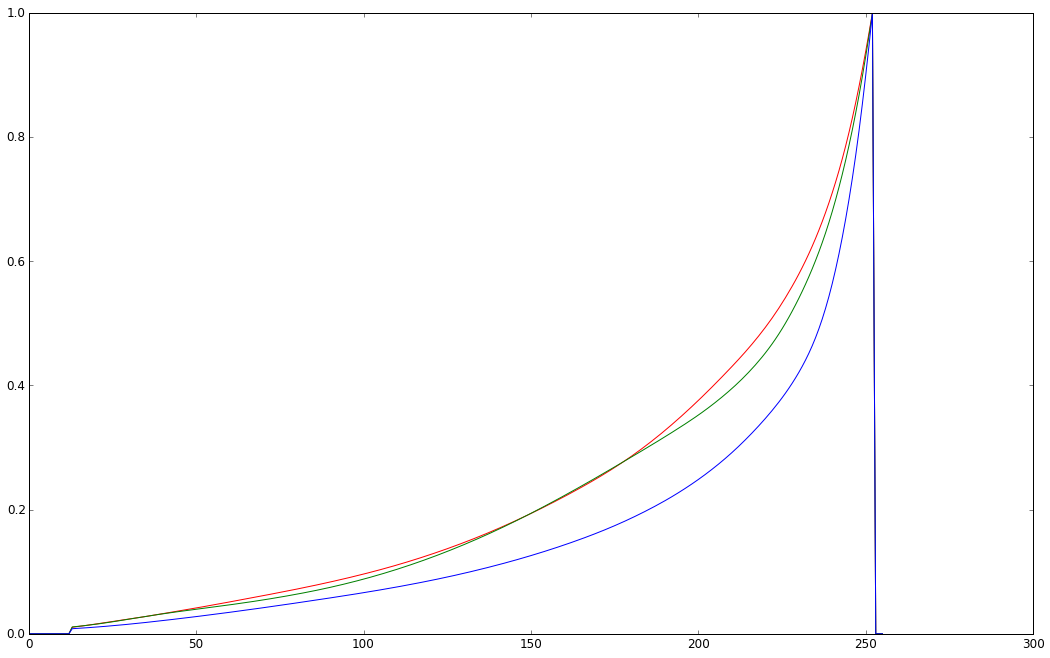

In [3]:
weighting_function_custom = lambda x: weighting_function_Debevec1997(x, 0.05, 0.99)

CRFS = camera_response_function_Debevec1997(
    ImageStack.from_files(JPG_FILES[2:5]), w=weighting_function_custom)

pylab.plot(CRFS)
pylab.show()

In [4]:
def example_merge_from_jpg_files(
        jpg_files,
        output_directory,
        camera_response_functions,
        batch_size=5,
        weighting_function=weighting_function_custom):
    for jpg_files in colour.batch(jpg_files, batch_size):
        image_stack = ImageStack.from_files(jpg_files)

        path = os.path.join(
            output_directory,
            '{0}_{1}_MLF.{2}'.format(
                os.path.splitext(os.path.basename(image_stack.path[0]))[0],
                batch_size,
                'exr'))
        
        LOGGER.info('Merging "{0}"...'.format(path))
        LOGGER.info('\tImage stack "F Number" (Exif): {0}'.format(
            image_stack.f_number))
        LOGGER.info('\tImage stack "Exposure Time" (Exif): {0}'.format(
            image_stack.exposure_time))
        LOGGER.info('\tImage stack "ISO" (Exif): {0}'.format(
            image_stack.iso))
        image = radiance_image(image_stack,
                               weighting_function,
                               camera_response_functions=camera_response_functions)
        image[np.isnan(image)] = 0
        
        LOGGER.info('Writing "{0}"...'.format(path))
        colour.write_image(image, path)

        return image, path

IMAGE, PATH = example_merge_from_jpg_files(JPG_FILES, RESOURCES_DIRECTORY, CRFS)

INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2598.jpg" image.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2598.jpg" image metadata.
INFO:colour_hdri.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2598.jpg' file exif data.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2599.jpg" image.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2599.jpg" image metadata.
INFO:colour_hdri.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2599.jpg' file exif data.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Develop

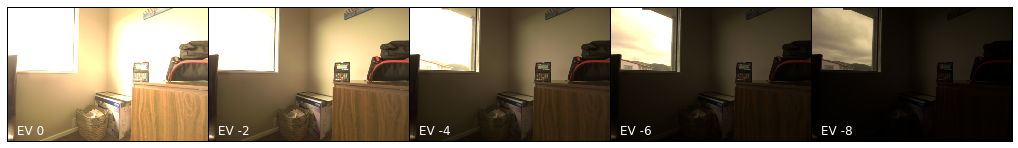

In [5]:
radiance_image_strip_plot(IMAGE)